# BOLD rs-fMRI: confounds classifier

Are confounding variables, such as motion and global signals, capable of classifying AVGP from NVGP?

Below, we use a list of confounds extracted using fmriprep during preprocessing to predict subject group. Se expect to see a no significant difference from chance level as measured by prediction accuracy.

## Setup

To prepare the development environment, run:

```
mamba create -n tf
mamba activate tf
mamba install tensorflow-cpu

mamba install nilearn matplotlib seaborn tqdm

pip install scikeras --no-deps

# ray
pip install tune-sklearn pyarrow "ray[tune]" "ray[data]" -U
```

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.interfaces.bids import get_bids_files
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from tqdm import tqdm

from ray.tune.sklearn import TuneSearchCV 

## Prepare Data

In [35]:
# Prepare the path to the confound data

confound_files = get_bids_files(
    'data/julia2018/derivatives/fmriprep_2020',
    # file_tag='timeseries',
    modality_folder='func',
    filters=[('ses', 'rest'), ('desc', 'confounds')],
    file_type='tsv')

In [59]:
# prepare Xy

_confounds_lst = []

for confound_file in tqdm(confound_files, desc='Loading confounds'):
    df = pd.read_csv(confound_file, sep='\t')
    df['timestep'] = df.index + 1
    df['subject'] = confound_file.split('/')[4].replace('sub-','')
    _confounds_lst.append(df)

confounds = pd.concat(_confounds_lst).reset_index(drop=True)

# all the features (time-series of the confounds, groups, subjects)
X = confounds.dropna(axis=1)
y = confounds['subject'].apply(lambda x: x[:4])

#  3d (subject, timestep, confound)
X_ts = X.groupby('subject').apply(lambda grp:
    np.stack(grp.sort_values('timestep').drop(columns=['timestep','subject']).values))
y_ts = X_ts.index.to_series().apply(lambda x: x[:4])

# mean confounds
X_mean = confounds.groupby('subject').mean().drop(columns=['timestep']).dropna(axis=1)
y_mean = X_mean.index.to_series().apply(lambda x: x[:4])

y_mean_onehot = pd.get_dummies(y_mean)

Loading confounds: 100%|██████████| 32/32 [00:00<00:00, 98.25it/s] 


## Pipeline and hyper-parameter tuning

In [60]:
pipe = Pipeline([
    ('zero_var', VarianceThreshold()),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('clf', SVC())
])

# Grid Search
param_grid = {
    'scale': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'select': [SelectFromModel(SVC(kernel='linear')), 'passthrough'],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10, 100],
}

# Bayesian Search
param_dists = {
    'scale': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'select': [SelectFromModel(SVC(kernel='linear')), 'passthrough'],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': (1e-2, 1e3, 'log-uniform'),
}

# Scikit-learn Grid Search
# grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)

# Ray Tune Grid/Bayesian Search
grid = TuneSearchCV(
    pipe,
    param_dists,
    cv=5,
    # n_trials=3,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='bayesian',
    verbose=1,
    scoring='accuracy',
    n_jobs=-1)

# hyper-parameter optimization (the best parameters are available via  grid.best_params_)
grid.fit(X_mean, y_mean)
print('Best estimator:', grid.best_estimator_)

2022-04-09 04:04:38,254	INFO tune.py:639 -- Total run time: 43.46 seconds (42.27 seconds for the tuning loop).


Best estimator: Pipeline(steps=[('zero_var', VarianceThreshold()), ('scale', MinMaxScaler()),
                ('select', 'passthrough'),
                ('clf', SVC(C=1.4420425347576453, kernel='linear'))])


## Cross-validated model fitting

In [61]:

# cross-validated model fitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1000)

scores = cross_val_score(grid.best_estimator_,
                         X_mean, y_mean,
                         cv=cv, scoring='accuracy',
                         n_jobs=-1, verbose=1)

print(f'[SVM] Validation score (mean/std): {scores.mean():.3f}/{np.std(scores):.3f}')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   12.6s
Map Progress:   0%|          | 0/32 [06:34<?, ?it/s]


[SVM] Validation score (mean/std): 0.498/0.178


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   18.6s finished


## Simple deep learning model

Let's also try a keras-based deep learning pipeline.

In [124]:
from scikeras.wrappers import KerasClassifier
from tensorflow import keras

def build_model(input_dim):
    clf = keras.models.Sequential()
    clf.add(keras.layers.Dense(10, activation='relu', input_dim=input_dim))
    clf.add(keras.layers.Dense(2, activation='softmax'))
    clf.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return clf

keras_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', KerasClassifier(build_model, verbose=0, input_dim=X_mean.shape[1], epochs=100))
])

# cross-validated model fitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

keras_scores = []

for train, test in tqdm(cv.split(X_mean, y_mean), total=cv.get_n_splits()):
    X_train, X_test = X_mean.iloc[train], X_mean.iloc[test]
    y_train, y_test = y_mean_onehot.iloc[train], y_mean_onehot.iloc[test]

    keras_pipe.fit(X_train, y_train)
    score = keras_pipe.score(X_test, y_test)

    keras_scores.append(score)

print(f'[DL] Validation score (mean/std): {np.mean(keras_scores):.3f}/{np.std(keras_scores):.3f}')


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]

[DL] Validation score (mean/std): 0.500/0.177


##  LSTM classifier

The classification model below takes sequences of confounds and predicts the group of the subject.

In [125]:
# fit a LSTM to the sequence of confounds

def build_lstm_model():
    model = keras.models.Sequential()
    n_timesteps = X_ts[0].shape[0]
    n_features = X_ts[0].shape[1]
    model.add(keras.layers.LSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # print(model.summary())
    return model

lstm_pipe = KerasClassifier(build_lstm_model, verbose=0, epochs=100)

# cross-validated model fitting
lstm_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

lstm_scores = []

for train, test in tqdm(lstm_cv.split(X_ts, y_mean), total=lstm_cv.get_n_splits()):
    X_train, X_test = np.stack(X_ts.iloc[train]), np.stack(X_ts.iloc[test])
    y_train, y_test = y_ts.iloc[train], y_ts.iloc[test]

    lstm_pipe.fit(X_train, y_train)

    score = lstm_pipe.score(X_test, y_test)
    lstm_scores.append(score)

print(f'[LSTM] Validation score (mean/std): {np.mean(lstm_scores):.3f}/{np.std(lstm_scores):.3f}')

100%|██████████| 10/10 [01:15<00:00,  7.56s/it]

[LSTM] Validation score (mean/std): 0.462/0.180


## Chance level

In [127]:
chance_model = DummyClassifier(strategy='most_frequent')

chance_scores = cross_val_score(
    chance_model,
    X_ts, y_ts,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1, verbose=1)

print(f'[Chance] Validation score (mean/std): {chance_scores.mean():.3f}/{np.std(chance_scores):.3f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Chance] Validation score (mean/std): 0.471/0.035


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


## Feature importance

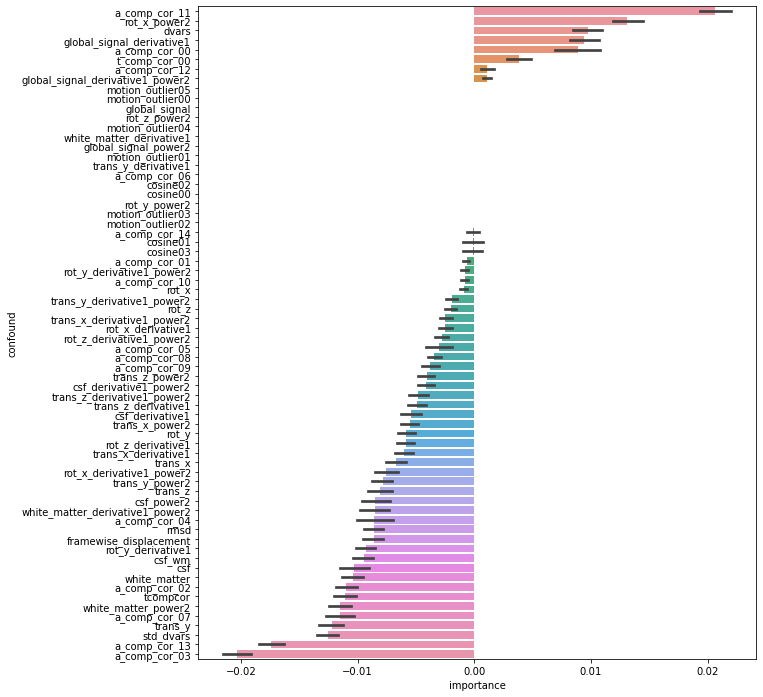

In [128]:
perm_results = permutation_importance(grid.best_estimator_,
                                      X_mean, y_mean,
                                      n_repeats=1000,
                                      scoring='accuracy',
                                      n_jobs=-1)

perm_importances = pd.DataFrame(perm_results.importances, index=X_mean.columns)

perm_importances = perm_importances.reset_index().rename(columns={'index':'confound'})
perm_importances = perm_importances.melt(
    id_vars=['confound'],
    var_name='cv_repetition',
    value_name='importance')

perm_importances['mean_importance'] = perm_importances.groupby('confound')['importance'].transform('mean')
perm_importances = perm_importances.sort_values(by='mean_importance', ascending=False)

_, ax = plt.subplots(1, 1, figsize=(10,12))
sns.barplot(data=perm_importances, x='importance', y='confound', orient='h', ax=ax)
plt.show()
